In [2]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import pandas as pd

In [3]:
from gettingsegments import extract_segments, plot_signal

## Getting the data

In [4]:
current_dir = os.getcwd()
os.chdir('c:\\Users\\Melanie\\OneDrive - Rensselaer Polytechnic Institute\\Desktop\\School\\24_Spring\\MLE\\Project\\data')

electrode_locations = {"FP1": 0, "FP2": 1, "FC5": 2, "FC6": 3, "FZ": 4,
                        "T7": 5, "CZ": 6, "T8": 7, "P7": 8, "P3": 9, "PZ": 10,
                          "P4": 11, "P8": 12, "O1": 13, "Oz": 14, "O2": 15}

files = os.listdir()
#getting the demographics both gets rid of that column and imports it 
demographics = pd.read_csv(files.pop(0),names=["Isman","Age","Fatigue"])
n = np.shape(demographics)[0]

In [5]:
#getting the signal for person 1
t, signal, section_num, class_bool, p_num = extract_segments(files[0])

### I'm going to start with a 1d CNN

the reason is because I'd like to start with something that is easier in the time-complexity sense

In [6]:
"""Doing PCA on the whole dataset to further reduce time"""
pca = PCA(whiten = True, n_components = 0.99) #whiten means making mean = 0, sd = 1

new_signal = pca.fit_transform(signal.T).T

In [46]:
"""Separating out the data into testing and training. I think i'll do leave
one out cross validation, so I'll just test it by taking the first one out 
first"""
segments = new_signal.T.reshape((10,5121,np.shape(new_signal)[0]))
y_segments = class_bool.reshape((10, 5121)).T[0]
y_segments[y_segments == 2] = 0
segment_shape = np.shape(segments)

X_train, X_test = segments[1:], segments[0]
y_train, y_test = y_segments[1:].flatten(), y_segments[0]
X_test = X_test.reshape(1, np.shape(X_test)[0], np.shape(X_test)[1])

array([0., 1., 0., 1., 0., 1., 0., 1., 0.])

In [9]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [10]:
from tensorflow import config
config.run_functions_eagerly(True)

In [12]:
model = Sequential()
#the layers
kernal_size = 10
model.add(Conv1D(filters=32, #this is the number of filters
                 kernel_size=kernal_size,
                 #set the activation function
                 activation='relu', 
                 input_shape = segment_shape[1:]))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=16, 
                 kernel_size=kernal_size,
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=16, 
                 kernel_size=kernal_size,
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=16, 
                 kernel_size=kernal_size,
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=16, 
                 kernel_size=kernal_size,
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(filters=16, 
                 kernel_size=kernal_size,
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64, #number of units
                activation='relu'))
model.add(Dense(8, #64 neurons
                activation='sigmoid')) #maybe u can try tanh
#compiler
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 5112, 32)          1952      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2556, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2547, 16)          5136      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1273, 16)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1264, 16)          2576      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 632, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 623, 16)          

In [48]:
# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
1/1 [==============================] - 0s 61ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 0s 28ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 3/10
1/1 [==============================] - 0s 30ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 4/10
1/1 [==============================] - 0s 28ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 5/10
1/1 [==============================] - 0s 35ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 0s 27ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 0s 31ms/step - loss: 7.6666 - accuracy: 0.5000 - val_loss: 10.2222 - val_accuracy: 0.6667
Epoch 8/10
1/1 [====

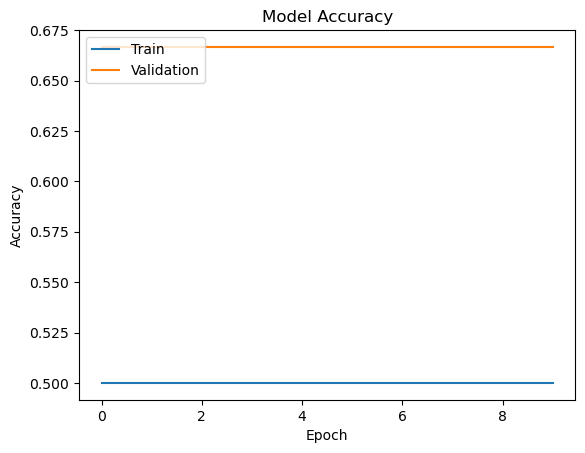

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
model.predict(X_test, batch_size=32)

array([[1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)